In [1]:
!pip install category_encoders

     |████████████████████████████████| 82 kB 208 kB/s 


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style='white')

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor

import pickle as pk

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/felipedidier/calculadora_de_aluguel/main/train_test.csv', encoding='utf-8-sig')

In [7]:
df = df.drop(columns='Unnamed: 0')
df = df.drop(columns='garage')
df = df.drop(columns='neigh')

In [8]:
df.head()

,price,area,room,bath
0,340000.0,71.0,3.0,3.0
1,149990.0,41.0,2.0,1.0
2,152990.0,41.0,2.0,1.0
3,430000.0,120.0,3.0,5.0
4,235000.0,55.0,2.0,1.0


## Train and Test

In [14]:
train, test = train_test_split(df, test_size=0.2, random_state=42)
X_train, y_train = train.drop(columns="price"), train["price"]
X_test, y_test = test.drop(columns="price"), test["price"]

In [28]:
select = ['area', 'room', 'bath']

In [15]:
z_score = StandardScaler()

In [29]:
preprocess = ColumnTransformer(
                    [   
                        ('StdTransf', z_score, select)
                    ], remainder='passthrough')

In [30]:
dt_tf = preprocess.fit_transform(X_train, y_train)

In [32]:
pd.DataFrame(data = dt_tf,columns=select).head()

,area,room,bath
0,0.128792,0.726625,0.639990
1,0.564740,0.726625,0.639990
2,-0.910777,-0.900798,-0.341328
3,-0.877243,-0.900798,-0.341328
4,0.631809,0.726625,0.639990


In [34]:
model = TransformedTargetRegressor(regressor=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5, max_features='auto', random_state=42), transformer = z_score)

In [35]:
pipe = Pipeline([("pre", preprocess), ("tree", model)])
pipe.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


Pipeline(steps=[('pre',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('StdTransf', StandardScaler(),
                                                  ['area', 'room', 'bath'])])),
                ('tree',
                 TransformedTargetRegressor(regressor=RandomForestRegressor(criterion='mse',
                                                                            max_depth=5,
                                                                            random_state=42),
                                            transformer=StandardScaler()))])

In [36]:
## Test
pred_value = pipe.predict(X_test)

mse_dt = mean_squared_error(y_test, pred_value)

rmse_dt = mse_dt ** (1/2)

print("Test set MSE of dt: {:.3f}".format(mse_dt))
print("Test set RMSE of dt: {:.3f}".format(rmse_dt))
print(f"Test set R2 of dt {r2_score(y_test, pred_value):.3f}")

Test set MSE of dt: 16175288404.146
Test set RMSE of dt: 127182.107
Test set R2 of dt 0.609


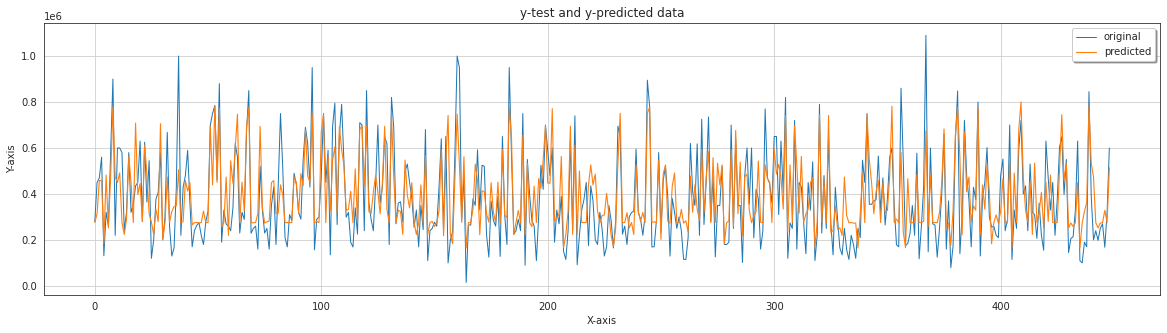

In [37]:
plt.figure(figsize=(20,5))
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, linewidth=1, label="original")
plt.plot(x_ax, pred_value, linewidth=1.1, label="predicted")
plt.title("y-test and y-predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 

## Gerando arquivo Pickle

In [40]:
pk.dump(pipe, open('model_rfr.pkl', 'wb'))